In [1]:
from fenics import *
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
set_log_level(30)
import random
from dolfin import interpolate, Expression, FunctionSpace, Constant, UserExpression
from dotenv import load_dotenv
import os
load_dotenv()
import numpy as np
import math

In [2]:
nueva_ruta = '/media/erick/TOSHIBA EXT/pruebas_mu_cero'
# Cambiar al nuevo directorio
os.chdir(nueva_ruta)

In [3]:
save_images = os.getenv('SAVE_IMAGES')

# Define constants alpha and beta
D_c = float(os.getenv('D_c'))
D_s = float(os.getenv('D_s'))
D_i = float(os.getenv('D_i'))

rc = float(os.getenv('rc'))
rs = float(os.getenv('rs'))
rd = float(os.getenv('rd'))

alpha = float(os.getenv('alpha'))
delta = float(os.getenv('delta'))
beta = float(os.getenv('beta'))
alle = float(os.getenv('alle'))
gamma = float(os.getenv('gamma'))
eta = float(os.getenv('eta'))
mu = float(os.getenv('mu'))
# mu = 0

# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))

# Define mesh and space
nodes_in_xaxis = int(os.getenv('nodes_in_xaxis'))
nodes_in_yaxis = int(os.getenv('nodes_in_yaxis'))
space_size = int(os.getenv('space_size'))


# Condición inicial en donde el cancer se origina en puntos
centers = [(5, 5), (15, 15)]  # Coordenadas donde el cáncer se origina
radius = 2.0  # Radio alrededor de los centros
value_outside = 0.0  # Valor fuera de los radios
value_inside = 0.9  # Valor dentro de los radios



In [4]:
# Condición inicial aleatoria
class RandomExpression(UserExpression):
    def __init__(self, min_val, max_val, **kwargs):
        super().__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val

    def eval(self, value, x):
        value[0] = random.uniform(self.min_val, self.max_val)

In [5]:
class CancerInitialCondition(UserExpression):
    def __init__(self, centers, radius, value_outside, value_inside, **kwargs):
        super().__init__(**kwargs)
        self.centers = centers  # Lista de centros (coordenadas) donde el cáncer se origina
        self.radius = radius  # Radio alrededor de los centros donde se inicia el cáncer
        self.value_outside = value_outside  # Valor fuera de los radios
        self.value_inside = value_inside  # Valor dentro de los radios

    def eval(self, value, x):
        value[0] = self.value_outside  # Valor inicial fuera de los radios

        # Verifica si el punto x está dentro de algún radio definido
        for center in self.centers:
            distance = math.sqrt((x[0] - center[0])**2 + (x[1] - center[1])**2)
            if distance <= self.radius:
                value[0] = self.value_inside  # Valor inicial dentro del radio
                break

In [6]:
def NonlinearSolver(F, field):
    J = derivative(F, field)
    problem = NonlinearVariationalProblem(F, field, bcs=[], J=J)
    solver = NonlinearVariationalSolver(problem)
    
    prm = solver.parameters["snes_solver"]
    prm["method"] = "vinewtonrsls"
    prm["maximum_iterations"] = 10000  # Aumentar el número máximo de iteraciones
    prm["relative_tolerance"] = 1e-6   # Relajar la tolerancia relativa
    prm["absolute_tolerance"] = 1e-8   # Relajar la tolerancia absoluta
    prm["linear_solver"] = "mumps"
    prm["preconditioner"] = "none"
    prm["report"] = True
    prm["error_on_nonconvergence"] = False

    linear_solver_options = ["cg", "gmres", "bicgstab"]
    preconditioner_options = ["ilu", "amg", "icc"]
    
    for linear_solver in linear_solver_options:
        for preconditioner in preconditioner_options:
            solver.parameters["snes_solver"]["linear_solver"] = linear_solver
            solver.parameters["snes_solver"]["preconditioner"] = preconditioner
            try:
                solver.solve()
                return solver
            except RuntimeError as e:
                print(f"Failed with linear_solver={linear_solver} and preconditioner={preconditioner}: {e}")
                continue

    raise RuntimeError("No se pudo resolver el sistema no lineal con ninguno de los métodos probados.")

In [7]:
def field_to_numpy_array(fenics_field, space_size, step, field_name, nb, sample_rate=0.1): 
    # Determina el número de muestras según el tamaño del espacio y la tasa de muestreo
    sample_points = np.arange(0, space_size + sample_rate, sample_rate)
    field_array = np.empty((len(sample_points), len(sample_points)), dtype=float)

    for i, val_x in enumerate(sample_points):
        for j, val_y in enumerate(sample_points):
            try:
                # Evaluar el campo de FEniCS en los puntos de muestra
                valor = fenics_field(val_x, val_y)
            except:
                valor = 0  # Si hay un error, asigna 0

            field_array[i, j] = valor
    N_field = "matrix_"  + field_name +"_"+ str(step) + "_" + "nb_" + str(nb) + ".txt"
    np.savetxt(N_field, field_array, delimiter="\t")
    return None

In [8]:
def plot_fields(field_1, field_2, field_3, block):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 3, 1)
    p1 = plot(field_1)
    p1.set_cmap("seismic")
    plt.title(f'Solution for c at time {t:.3f}')
    aspect = 20
    pad_fraction = 0.5
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    width = axes_size.AxesY(ax, aspect=1./aspect)
    pad = axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.colorbar(p1, cax=cax)


    plt.subplot(1, 3, 2)
    p2 = plot(field_2)
    p2.set_cmap("gray")
    plt.title(f'Solution for s at time {t:.3f}')
    aspect = 20
    pad_fraction = 0.5
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    width = axes_size.AxesY(ax, aspect=1./aspect)
    pad = axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.colorbar(p2, cax=cax)
    
    plt.subplot(1, 3, 3)
    p3 = plot(field_3)
    p3.set_cmap("viridis")
    plt.title(f'Solution for i at time {t:.3f}')
    aspect = 20
    pad_fraction = 0.5
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    width = axes_size.AxesY(ax, aspect=1./aspect)
    pad = axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.colorbar(p3, cax=cax)

    plt.tight_layout(pad=4)
    if save_images == 'Y':
        plt.savefig(f'fields_block_{block}._step_{t:.3f}.png')
        plt.show()
        pass
    else:
        pass
        plt.show()

In [9]:
def create_space_function(space_size, nodes_in_xaxis, nodes_in_yaxis):
    # Create mesh and define function space
    p0 = Point(0.0, 0.0)
    p1 = Point(space_size,space_size)
    mesh = RectangleMesh(p0, p1, nodes_in_xaxis, nodes_in_yaxis,"right/left")

    V = FunctionSpace(mesh, 'P', 1)
    return V

In [10]:
def solve_dynamics():

    # Define functions for c, s, and i
    V = create_space_function(space_size, nodes_in_xaxis, nodes_in_yaxis)

    c = Function(V)
    s = Function(V)
    i = Function(V)
    phi_c = TestFunction(V)
    phi_s = TestFunction(V)
    phi_i = TestFunction(V)

    # Define the Jacobian, variational problem and solver for each problem
    # # Define the weak forms for the equations with time dependence
    # Condición inicial aleatoria
    
    c_n = interpolate(RandomExpression(min_val=0.2, max_val=0.4, degree=2), V)
    # c_n = interpolate(CancerInitialCondition(centers, radius, value_outside, value_inside, degree=2), V)


    # F_c = ((c - c_n) / dt) * phi_c * dx + D_c * dot(grad(c), grad(phi_c)) * dx + rc * c * (c - alle) * (1 - c) * phi_c * dx - c*(s*alpha + i*beta)* phi_c * dx - (((s**2*gamma + i**2*eta)*mu)/2 )* phi_c * dx
    F_c = ((c - c_n) / dt) * phi_c * dx + D_c * dot(grad(c), grad(phi_c)) * dx + rc * c * (c - alle) * (1 - c) * phi_c * dx - c*(s*alpha + i*beta)* phi_c * dx

    
    solver_c = NonlinearSolver(F_c, c)


    # Condición inicial aleatoria
    s_n = interpolate(RandomExpression(min_val=0.8, max_val=1.2, degree=2), V)

    # F_s = ((s - s_n) / dt) * phi_s * dx + D_s * dot(grad(s), grad(phi_s)) * dx + rs * s * (1 - s) * phi_s * dx - c*s*gamma* phi_s * dx + i**2*s*delta* phi_s * dx - ((c**2*alpha*mu)/2) * phi_s * dx
    F_s = ((s - s_n) / dt) * phi_s * dx + D_s * dot(grad(s), grad(phi_s)) * dx + rs * s * (1 - s) * phi_s * dx - c*s*gamma* phi_s * dx + i**2*s*delta* phi_s * dx 
    
    solver_s = NonlinearSolver(F_s, s)

    # Condición inicial aleatoria
    i_n = interpolate(RandomExpression(min_val=0.5, max_val=0.7, degree=2), V)

    # F_i = ((i - i_n) / dt) * phi_i * dx + D_i * dot(grad(i), grad(phi_i)) * dx + rd * i * (1 - i)* phi_i * dx + i*s**2*delta* phi_i * dx - c*i*eta* phi_i * dx - ((c**2*beta*mu)/2)* phi_i * dx
    F_i = ((i - i_n) / dt) * phi_i * dx + D_i * dot(grad(i), grad(phi_i)) * dx + rd * i * (1 - i)* phi_i * dx + i*s**2*delta* phi_i * dx - c*i*eta* phi_i * dx

    solver_i = NonlinearSolver(F_i, i)
    
    return solver_c, solver_s, solver_i, c, s, i, c_n, s_n, i_n, dx

bloque 1


KeyboardInterrupt: 

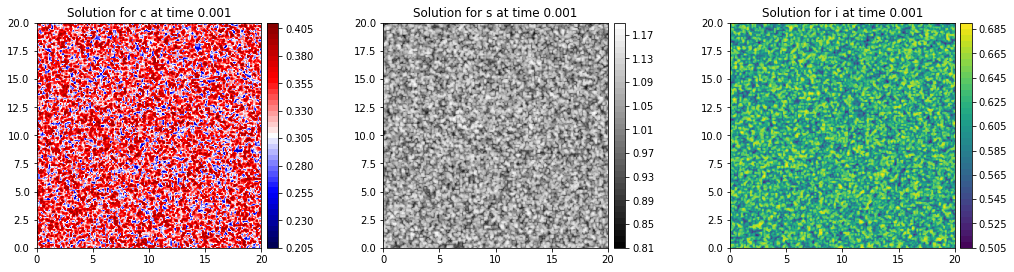

In [11]:
# for block in range(1,nb+1):
for block in range(1,2):
    # Time-stepping
    t = 0
    solver_c, solver_s, solver_i, c, s, i, c_n, s_n, i_n, dx = solve_dynamics()
    while (t < T):
        t += dt
        print('bloque', block)

        # Solve the system for the next time step
        solver_c.solve()
        solver_s.solve()
        solver_i.solve()

        # Update previous solution
        c_n.assign(c)
        s_n.assign(s)
        i_n.assign(i)

        field_to_numpy_array(c, space_size, "{:.3f}".format(t), "c", block)
        field_to_numpy_array(s, space_size, "{:.3f}".format(t), "s", block)
        field_to_numpy_array(i, space_size, "{:.3f}".format(t), "i", block)
        plot_fields(c_n, s_n, i_n, block)
